In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path
sys.path.append('../scenes/')
import syndiff as sd 

/Users/ryanr/miniconda3/lib/python3.7/site-packages/lightkurve/search.py:233: LightkurveWarning: Warning: 13 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  LightkurveWarning)


<IPython.core.display.Javascript object>


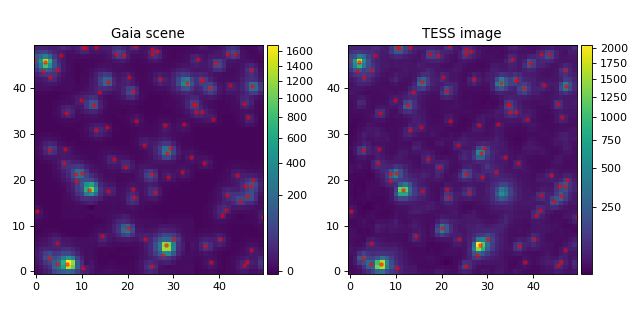

In [166]:
# single star
ra =  95.4586
dec = -51.2377
# SN2018fhw
ra = 64.5261250     
dec = -63.6150694
# SN2019esa
#ra = 118.7537042
#dec = -76.4119750 
     
# GRB 
#ra = 30.26933 
#dec = 24.50988

size = 20
scene,tpf = sd.Gaia_scene(ra,dec,50,Maglim=17,Interpolate=True,
                          FFT=False,PRF=True,Plot = True,Save='Gaia_scene.pdf')

In [157]:
bkg = np.ones_like(scene[0])
for s in scene:
    bkg = bkg * (s <= 5)

<IPython.core.display.Javascript object>


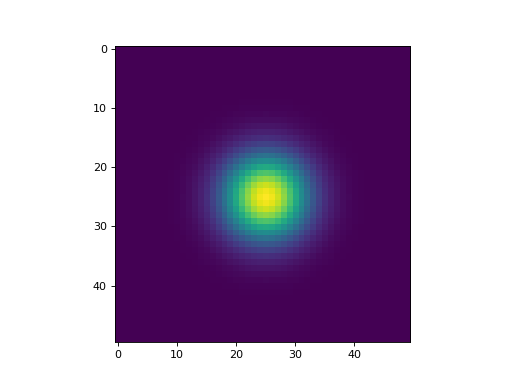

In [229]:
plt.figure()
plt.imshow(bkg,origin='lower')

In [190]:
from scipy.ndimage.filters import gaussian_filter

def Scene_bkg_estimate(Scene,tpf,Custom_mask = None,Limit = 5,Smoothing=5):
    """
    Determine the sky background of the real image by using the Scene.
    This works well for known surces, but wont work for random searches.
    Finds all sky pixels based off 'Limit' then interpolates the sky background 
    for the sources and masked areas. Workes well for large areas.

    -------
    Inputs-
    -------
        Scene 			array 	Array of images containing a source each 
        tpf 			class 	Target pixel file lighkurve class
        Custom_mask 	array 	Manual mask to ensure science target is masked
        Limit 			float 	Counts limit for determining sky pixels

    --------
    Outputs-
    --------
        bkg 			array 	Array with shape tpf.flux containing background 
                                flux for each frame. 
    """

    mask = np.ones_like(Scene[0])
    for s in Scene:
        mask = mask * (s <= Limit)
    if type(Custom_mask) != type(None):
        print('additional mask')
        mask = mask * Custom_mask
    bkg = np.zeros_like(tpf.flux)
    x = np.arange(0, mask.shape[1])
    y = np.arange(0, mask.shape[0])
    #mask invalid values
    for i in range(len(tpf.flux)):
        arr = tpf.flux[i]
        arr[mask==0] = np.nan
        arr = np.ma.masked_invalid(arr)
        xx, yy = np.meshgrid(x, y)
        #get only the valid values
        x1 = xx[~arr.mask]
        y1 = yy[~arr.mask]
        newarr = arr[~arr.mask]

        estimate = interpolate.griddata((x1, y1), newarr.ravel(),
                                  (xx, yy),method='linear')
        nans = np.where(np.isnan(estimate))
        # need a better way of doing this
        estimate[nans] = np.nanmedian(estimate)
        if Smoothing > 0:
            estimate = gaussian_filter(estimate,Smoothing,mode='constant')
        bkg[i] = estimate

    return bkg

<IPython.core.display.Javascript object>


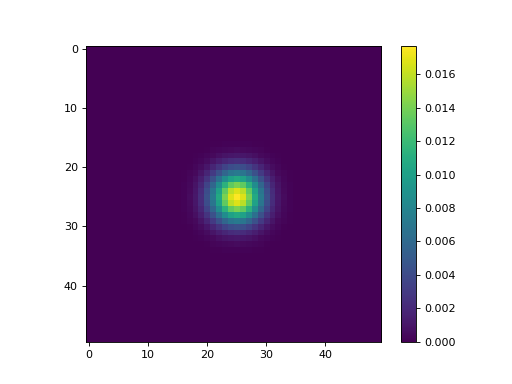

In [234]:
eh = np.zeros_like(clean[0])
eh[25,25] = 1 
eh = gaussian_filter(eh,3,mode='constant')
plt.figure()
plt.imshow(eh)
plt.colorbar()

In [226]:
cus = np.ones_like(tpf.flux[0])
cus[20:29,20:29] = 0
cus[14:21,30:38] = 0
none = Scene_bkg_estimate(scene,tpf,Custom_mask=cus,Smoothing=0)
some = Scene_bkg_estimate(scene,tpf,Custom_mask=cus,Smoothing=3)
much = Scene_bkg_estimate(scene,tpf,Custom_mask=cus,Smoothing=5)
clean = tpf.flux-none
clean2 = tpf.flux-some
clean3 = tpf.flux-much

additional mask
additional mask
additional mask


<IPython.core.display.Javascript object>


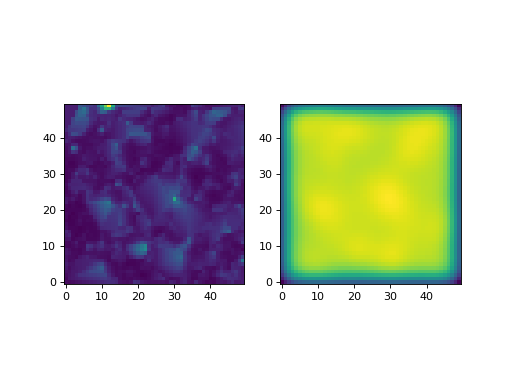

In [228]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(none[1000],origin='lower')
plt.subplot(1,2,2)
plt.imshow(some[100],origin='lower')

<IPython.core.display.Javascript object>


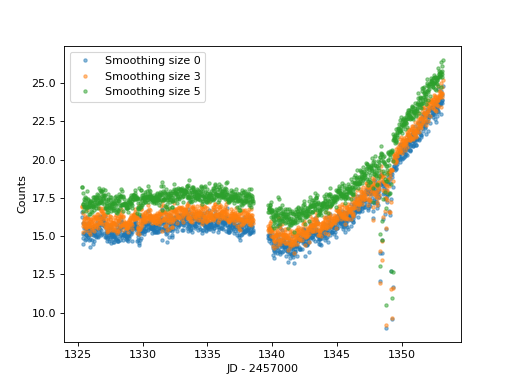

In [227]:

plt.figure()
plt.plot(tpf.astropy_time.jd-2457000,clean[:,25,25],'.',alpha=0.5,label='Smoothing size 0')
plt.plot(tpf.astropy_time.jd-2457000,clean2[:,25,25],'.',alpha=0.5,label='Smoothing size 3')
plt.plot(tpf.astropy_time.jd-2457000,clean3[:,25,25],'.',alpha=0.5,label='Smoothing size 5')
#plt.plot(clean[:,26,26])
#plt.plot(clean[:,24,24]-np.nanmedian(clean[:100,24,24]),'.')
#plt.xlim(1772.6,1773)
#plt.ylim(-1,40)
plt.ylabel('Counts')
plt.xlabel('JD - 2457000')
plt.legend()
plt.savefig('Smoothing_0_3_5.pdf')

In [238]:
tpf.header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
NEXTEND =                    2 / number of standard extensions                  
EXTNAME = 'PRIMARY '           / name of extension                              
EXTVER  =                    1 / extension version number (not format version)  
SIMDATA =                    F / file is based on simulated data                
ORIGIN  = 'STScI/MAST'         / institution responsible for creating this file 
DATE    = '2018-12-05'         / file creation date.                            
TSTART  =    1325.313100604524 / observation start time in TJD                  
TSTOP   =    1353.167256127407 / observation stop time in TJD                   
DATE-OBS= '2018-07-25T19:29:

# GRB test

In [102]:
from matplotlib import gridspec
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import MaxNLocator


<IPython.core.display.Javascript object>


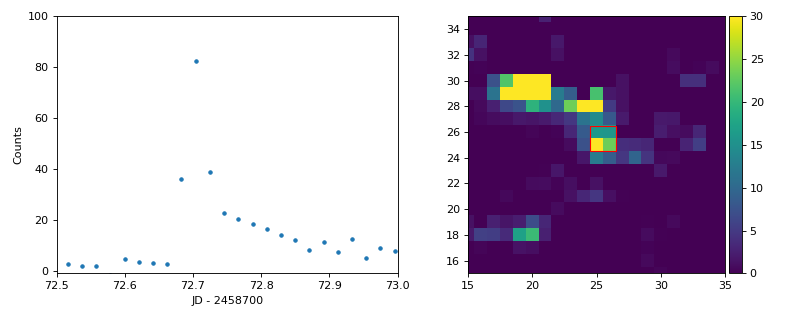

In [105]:
sub = tpf.flux-test
ref = np.nanmedian(sub[:100,25:27,25:27],axis=(0))
lc = np.nansum(sub[:,25:27,25:27]-ref,axis=(1,2))

#sub[sub<0] = np.nan
plt.figure(figsize=(10,4))
#plt.plot(tpf.astropy_time.jd-2457000,tpf.flux[:,26,26]/np.nanmax(tpf.flux[:,26,26]),'.')
#plt.plot(test[:,24,24])

plt.subplot(1,2,1)
#plt.plot(tpf.astropy_time.jd-2458700,sub[:,25,25]-np.nanmedian(sub[:100,25,25]),'.')
plt.plot(tpf.astropy_time.jd-2458700,lc-np.nanmedian(lc[:100]),'.')
plt.xlim(72.5,73)
plt.ylim(-1,100)
plt.ylabel('Counts')
plt.xlabel('JD - 2458700')
plt.subplot(1,2,2)
im = plt.imshow(sub[ind]-sub[10],origin='lower',vmin=0,vmax=30)
plt.ylim(15,35)
plt.xlim(15,35)
rect = patches.Rectangle((25-.5,25-.5),2,2,linewidth=1,edgecolor='r',facecolor='none')
ax = plt.gca()
ax.add_patch(rect)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

plt.colorbar(im, cax=cax)

plt.tight_layout()
#plt.savefig('grb_sndiff_bkd.pdf')

In [49]:
ind =np.where(1772.7 <= tpf.astropy_time.jd-2457000)[0][0]

<IPython.core.display.Javascript object>


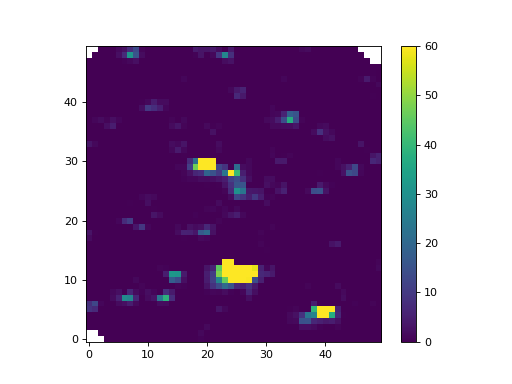

In [65]:
plt.figure()
plt.imshow(sub[ind]-sub[10],origin='lower',vmin=0,vmax=60)
plt.colorbar()

<IPython.core.display.Javascript object>


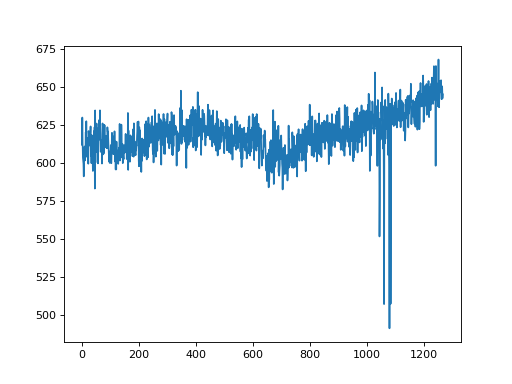

<IPython.core.display.Javascript object>


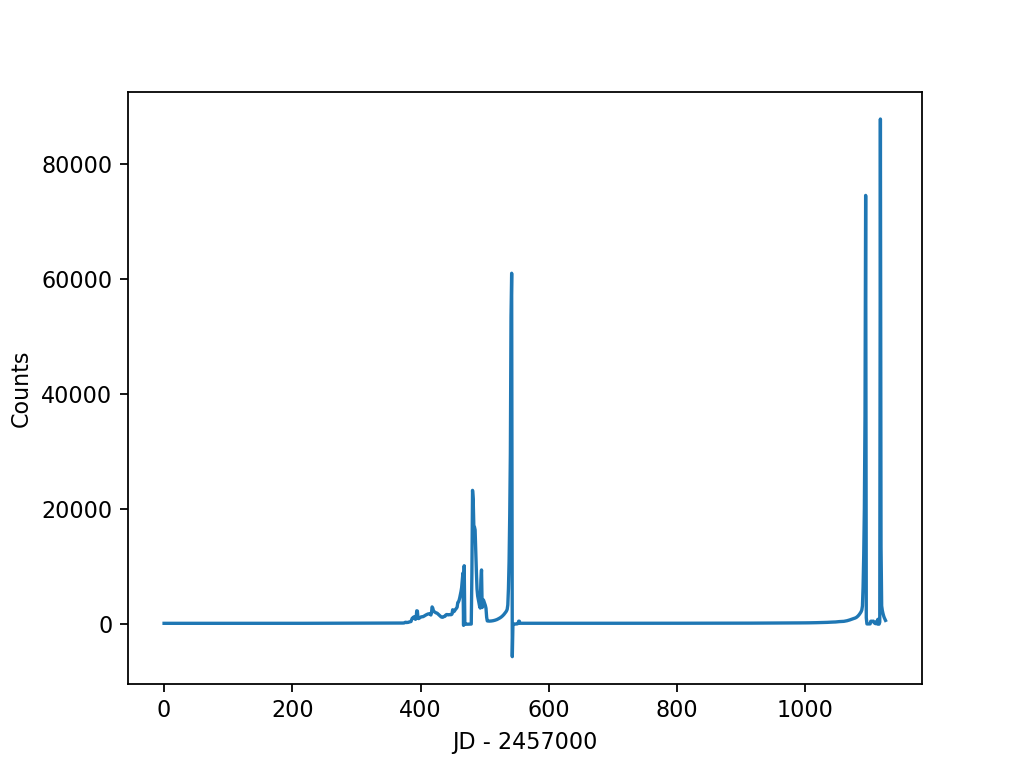

Text(0.5, 0, 'JD - 2457000')

In [128]:
plt.figure()
#plt.plot(tpf.astropy_time.jd-2457000,tpf.flux[:,26,26]/np.nanmax(tpf.flux[:,26,26]),'.')
plt.plot(test[:,25,25])
#plt.plot(sub[:,25,25]-np.nanmedian(sub[:100,25,25]),'.')
#plt.xlim(1772.6,1773)
#plt.ylim(-1,40)
plt.ylabel('Counts')
plt.xlabel('JD - 2457000')

<IPython.core.display.Javascript object>


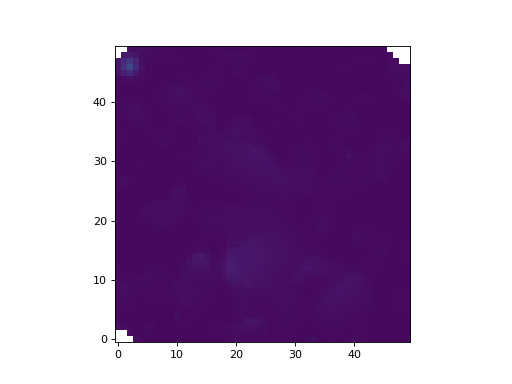

In [111]:
fig, ax = plt.subplots()

im = plt.imshow(test[0],origin='lower',vmin=100,vmax=1000)

In [112]:
im.set_data(test[1])

<IPython.core.display.Javascript object>


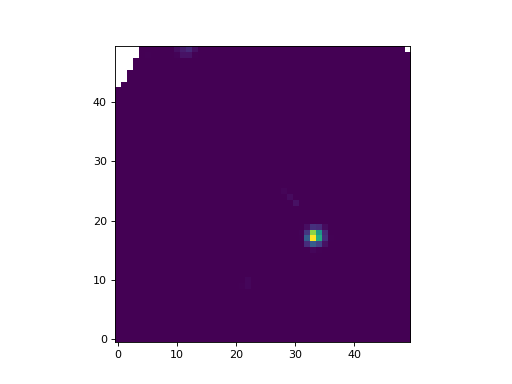

In [154]:
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from astropy.visualization import (SqrtStretch, ImageNormalize)

fig, ax = plt.subplots()
norm = ImageNormalize(vmin=np.nanmin(test), 
                      vmax=np.nanmax(test), stretch=SqrtStretch())
im = plt.imshow(test[0],origin='lower',vmin=100,vmax=500)


def init():  # only required for blitting to give a clean slate.
    im.set_data(np.nan * np.zeros_like(test[0]))
    return im,


def animate(i):
    im.set_data(test[i])
    return im,


anim = FuncAnimation(fig, animate, init_func=init,
                               frames=len(test), interval=20, blit=True)
anim.save("test_movie.mp4")

In [121]:
anim.save("test_movie.mp4")